In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
diabetic_data = pd.read_csv('diabetic_data.csv')
ids_mapping = pd.read_csv('IDS_mapping.csv')

In [3]:
print(diabetic_data.columns)
print(diabetic_data.shape)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
(101766, 50)


In [4]:
for column in diabetic_data.columns:
    print(column, len(diabetic_data[column].unique()), '? present' if '?' in diabetic_data[column].unique() else '', diabetic_data[column].unique())

encounter_id 101766  [  2278392    149190     64410 ... 443854148 443857166 443867222]
patient_nbr 71518  [  8222157  55629189  86047875 ... 140199494 120975314 175429310]
race 6 ? present ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender 3  ['Female' 'Male' 'Unknown/Invalid']
age 10  ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight 10 ? present ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id 8  [6 1 2 3 4 5 8 7]
discharge_disposition_id 26  [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id 17  [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital 14  [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code 18 ? present ['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty 73 ? present ['Pediatrics-Endocrinology' '?'

# insights
`encounter_id`: hay tantos datos únicos como filas, por lo que son únicos para cada dato, no va a servir de nada para predecir. Descartar.<br>
`patient_nbr`: id de los pacientes. Hay pacientes repetidos. No parece tener valores faltantes/indeterminados.<br>
`race`: tiene '?' para los faltantes y además 'Other'. No se si sería correcto hacer que todos los '?' sea hagan 'Other'. Puede ser que fuera xq no estaba dentro de las opciones distintas a 'Other' o xq simplemente no pusieron nada a pesar de estar en las otras. Habría que hacer alguna suposición xq la raza puede tener ingerencia en la respuesta a las enfermedades por genética.<br>
`age`: son rangos de edad hasta 100 años. Está completo<br>
`weight`: se tiene '?' para indeterminado<br>
`admission_type_id`: 8 opciones del 1 al 8<br>
`discharge_disposition_id`: 26 opciones<br>
`admission_source_id`: 17 opciones<br>
`time_in_hospital`: del 1 al 14 (serán meses?)<br>
`payer_code`: tiene '?' presente. Probablemente si estamos queriendo predecir algo de índole médico el código de pago mucha información no aporte...<br>
`medical_specialty`: tiene '?' presente. 72 opciones aparte del indeterminado<br>
`num_*`: todas tienen varias opciones, y ninguna tiene valor indeterminado '?'.<br>
`diag_[1-3]`: tienen '?' presente, y las 3 tienen alrededor de 800 valores únicos. No son todos valores númericos, hay alfanuméricos.<br>
`number_diagnoses`: entiendo es la cantidad de diagnósticos, de 1 a 16. <br>
`max_glu_serum`: tiene `nan` y después 3 valores categóricos.<br>
`A1Cresult`: tiene `nan` y después 3 valores categóricos.<br>
el resto tiene valores del estilo `No`, `Steady`, `Up`, `Down`.<br>
`examide` y `citoglipton` sólo tienen `No` como resultado -> se podrían descartar.

In [5]:
diabetic_data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


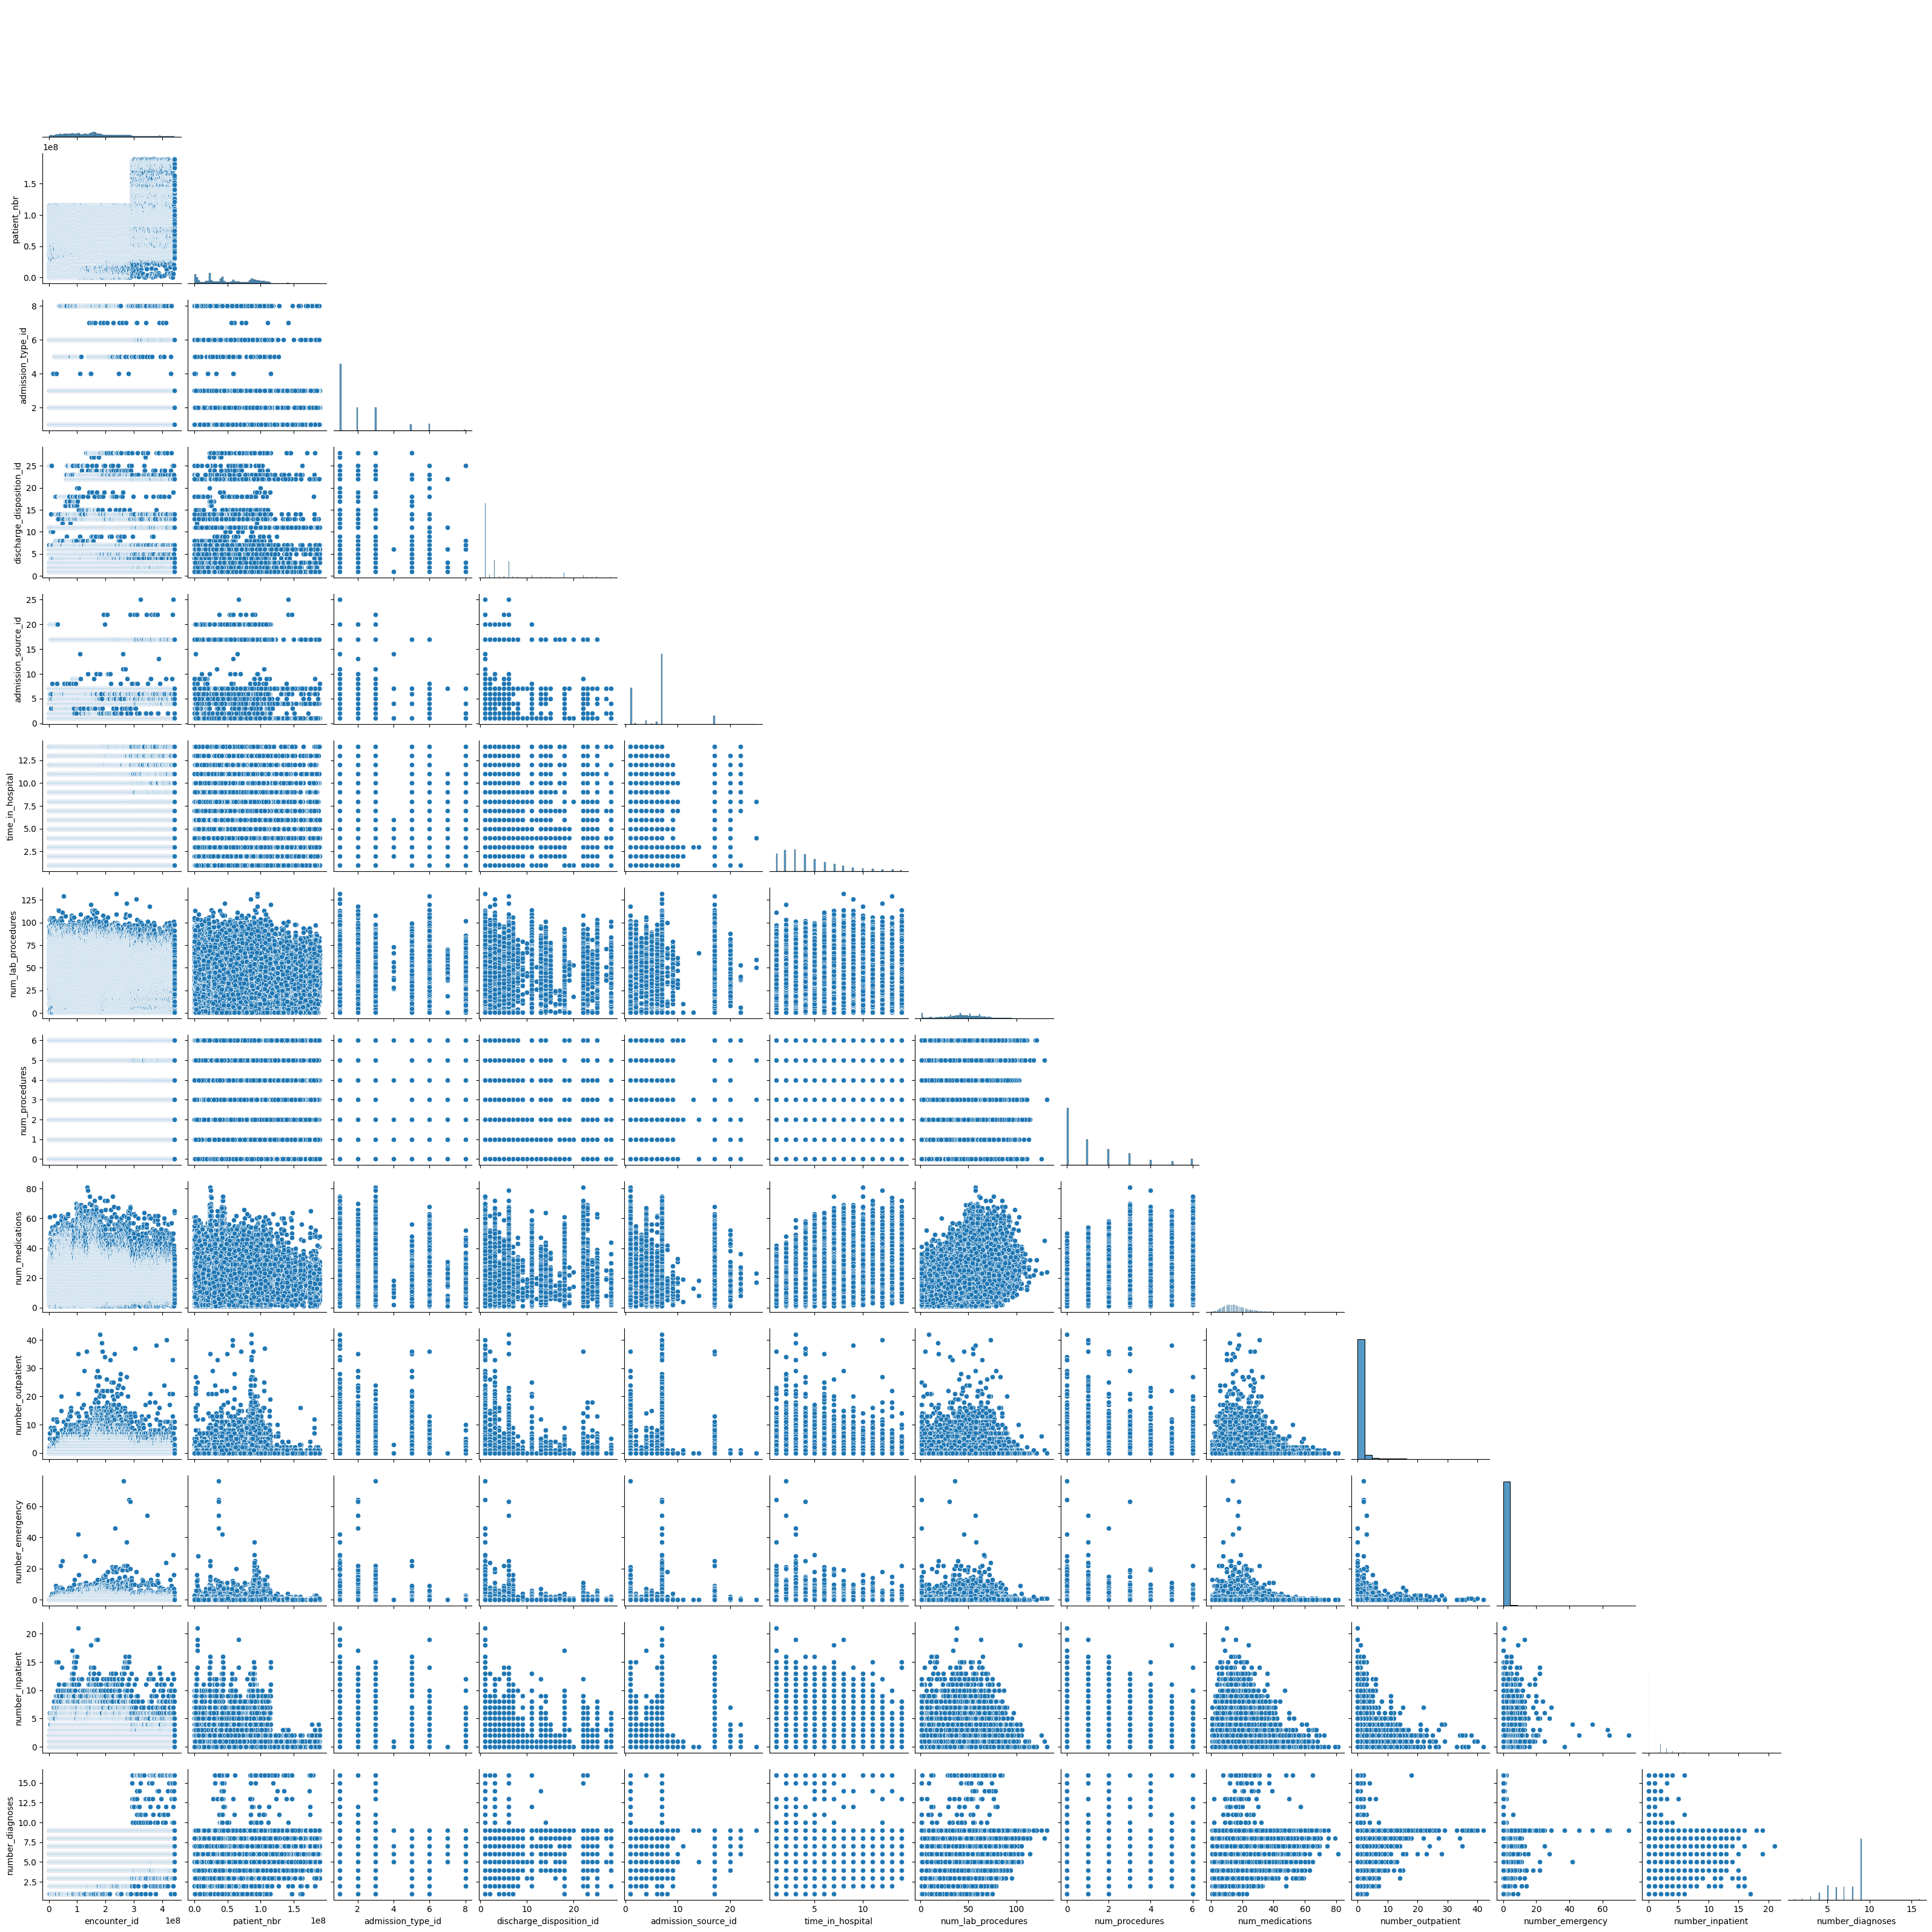

In [10]:
pair_plot = sns.pairplot(data=diabetic_data, diag_kind="hist", corner=True)

In [12]:
pair_plot.savefig('pairplot.png')

In [5]:
ids_mapping.columns

Index(['admission_type_id', 'description'], dtype='object')

In [7]:
ids_mapping

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
...,...,...
62,22,Transfer from hospital inpt/same fac reslt in...
63,23,Born inside this hospital
64,24,Born outside this hospital
65,25,Transfer from Ambulatory Surgery Center


In [131]:
for column in diabetic_data.columns:
    nan_values = diabetic_data[column].shape[0] - diabetic_data[column].count()
    total = diabetic_data[column].shape[0]
    value_counts = diabetic_data[column].value_counts()
    try:
        indef_values = value_counts['?']
    except:
        indef_values = 0
    if nan_values > 0 and indef_values > 0:
        print(f'{column} -> NaN: {nan_values} ({100*nan_values/total:.0f}%) ; ?: {indef_values} ({100*indef_values/total:.0f}%)')
    elif nan_values > 0:
        print(f'{column} -> NaN: {nan_values} ({100*nan_values/total:.0f}%)')
    elif indef_values > 0:
        print(f'{column} -> ?: {indef_values} ({100*indef_values/total:.0f}%)')

race -> ?: 2273 (2%)
weight -> ?: 98569 (97%)
payer_code -> ?: 40256 (40%)
medical_specialty -> ?: 49949 (49%)
diag_1 -> ?: 21 (0%)
diag_2 -> ?: 358 (0%)
diag_3 -> ?: 1423 (1%)
max_glu_serum -> NaN: 96420 (95%)
A1Cresult -> NaN: 84748 (83%)


Caucasian -> 76099 (74.78%)
AfricanAmerican -> 19210 (18.88%)
? -> 2273 (2.23%)
Hispanic -> 2037 (2.00%)
Other -> 1506 (1.48%)
Asian -> 641 (0.63%)
Female -> 54708 (53.76%)
Male -> 47055 (46.24%)
Unknown/Invalid -> 3 (0.00%)
[70-80) -> 26068 (25.62%)
[60-70) -> 22483 (22.09%)
[50-60) -> 17256 (16.96%)
[80-90) -> 17197 (16.90%)
[40-50) -> 9685 (9.52%)
[30-40) -> 3775 (3.71%)
[90-100) -> 2793 (2.74%)
[20-30) -> 1657 (1.63%)
[10-20) -> 691 (0.68%)
[0-10) -> 161 (0.16%)
Yes -> 78363 (77.00%)
No -> 23403 (23.00%)
NO -> 54864 (53.91%)
>30 -> 35545 (34.93%)
<30 -> 11357 (11.16%)
No -> 54755 (53.80%)
Ch -> 47011 (46.20%)


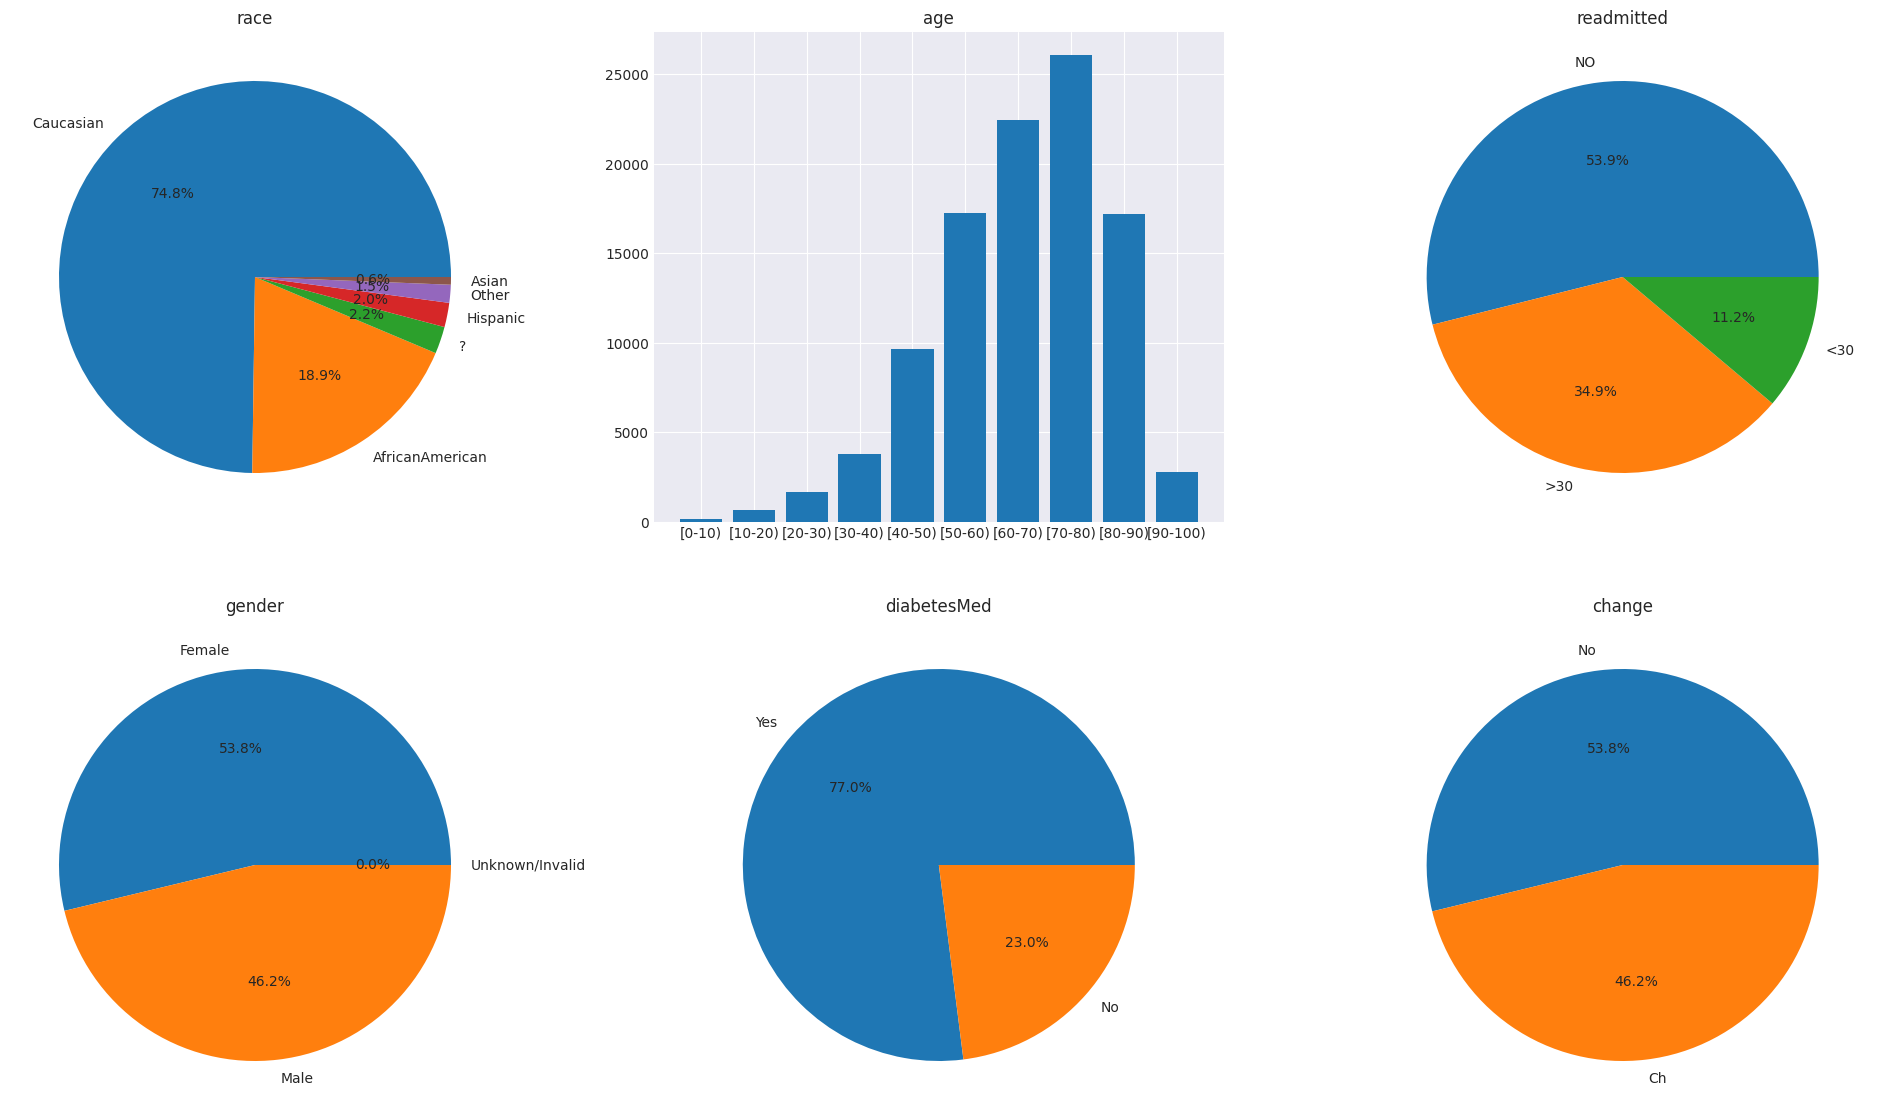

In [140]:
fig, axs = plt.subplots(2, 3, figsize=(25,14))
for i, column in enumerate(['race', 'gender', 'age', 'diabetesMed','readmitted','change']):
    value_counts = diabetic_data[column].value_counts(dropna=False)
    total = diabetic_data[column].shape[0]
    for value, label in zip(value_counts, value_counts.index):
        print(f'{label} -> {value} ({100 * value/total:.2f}%)')
    if column in ['age']:
        ages_ordered = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
        value_counts = value_counts.reindex(ages_ordered)
        axs[i%2][i//2].bar(range(len(value_counts)), value_counts)
        axs[i%2][i//2].set_xticks(range(len(value_counts)))
        axs[i%2][i//2].set_xticklabels(ages_ordered)
    else:
        axs[i%2][i//2].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    axs[i%2][i//2].set_title(column)
plt.show()

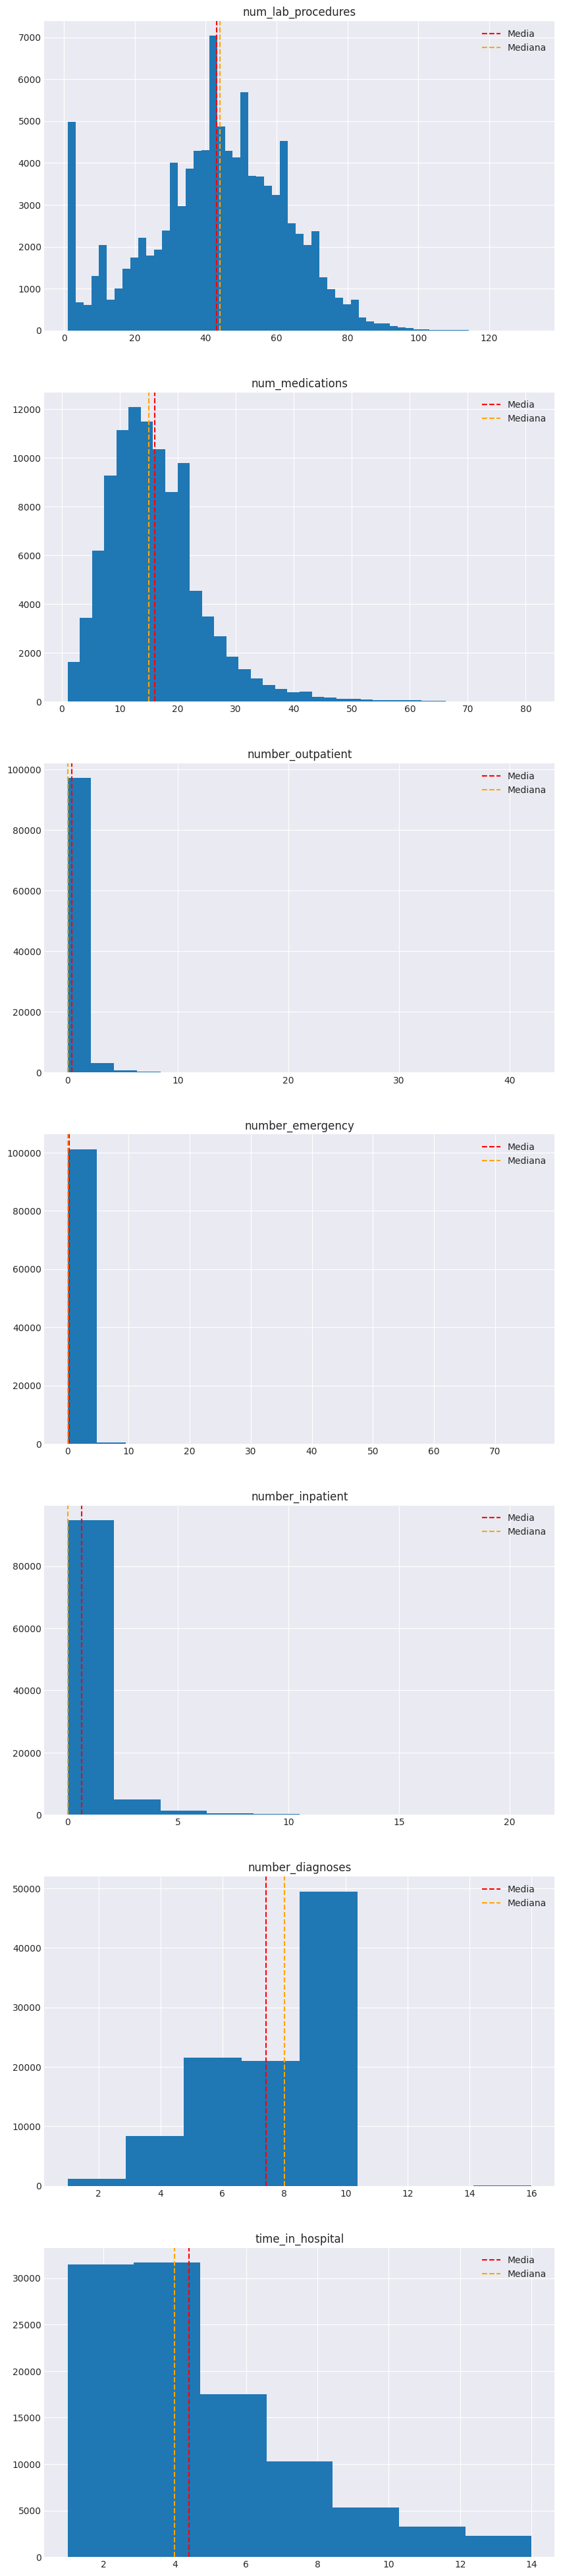

In [132]:
indexes = ['num_lab_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'time_in_hospital']
fig, axs = plt.subplots(len(indexes),1, figsize=(10,50))
for i, column in enumerate(indexes):
    num_col = diabetic_data[column]
    total_indexes = len(num_col.value_counts().index)
    bins = round(total_indexes/2) if total_indexes > 20 else total_indexes
    axs[i].hist(num_col, bins=round(len(num_col.value_counts().index)/2))
    axs[i].set_ylim(axs[i].get_ylim())
    axs[i].vlines([num_col.mean()], ymin=0, ymax=axs[i].get_ylim()[1], colors=['red'], linestyles=['dashed'], label='Media')
    axs[i].vlines([num_col.median()], ymin=0, ymax=axs[i].get_ylim()[1], colors=['orange'], linestyles=['dashed'], label='Mediana')
    axs[i].set_title(column)
    axs[i].legend()
plt.show()

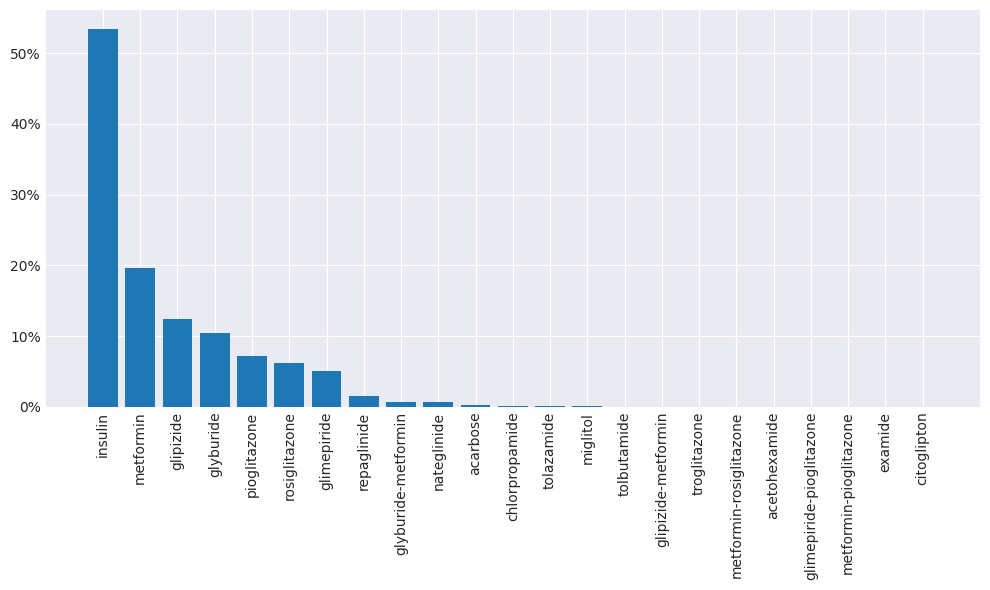

In [129]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
drugs_present = {}
for drug in drugs:
    drug_series = diabetic_data[drug]
    drug_values = drug_series.value_counts()
    drugs_present[drug] = drug_series.count() - drug_values['No']
drugs_present = pd.Series(drugs_present).sort_values(ascending=False)
fig, axs = plt.subplots(1,1, figsize=(10,6))
axs.bar(x=drugs_present.index, height=100*drugs_present.values/diabetic_data.shape[0])
axs.set_xticks(range(len(drugs_present.index)), drugs_present.index,rotation='vertical')
axs.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.show()